In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
df_true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
df_fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [4]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## We would use only text column for analysis here

In [6]:
df_true.drop(['title', 'subject', 'date'], axis = 1, inplace = True)
df_fake.drop(['title', 'subject', 'date'], axis = 1, inplace = True)

In [7]:
df_true['label'] = 1
df_fake['label'] = 0

In [8]:
df = pd.concat([df_true, df_fake], ignore_index = True)

In [9]:
num_examples = len(df)

In [10]:
#Step 1: Create a dataset
ds_raw = tf.data.Dataset.from_tensor_slices((df['text'].values, df['label'].values))
ds_raw = ds_raw.shuffle(num_examples, reshuffle_each_iteration = False)
for example in ds_raw.take(1):
    print(example[0].numpy()[:100])
    print(example[1])

b'If there s one thing that s certain about Donald Trump   you know, aside from his racism, misogyny, '
tf.Tensor(0, shape=(), dtype=int64)


In [11]:
#Train Val Test Splits
print(num_examples)

ds_temp = ds_raw.take(40000)
ds_test_raw = ds_raw.skip(40000)
ds_train_raw = ds_temp.take(38000)
ds_val_raw = ds_temp.skip(38000)

44898


In [12]:
#Step 2: Find unique tokens
from collections import Counter
token_count = Counter()

tokenizer = tfds.features.text.Tokenizer()

for example in ds_train_raw:
    tokens = tokenizer.tokenize(example[0].numpy())
    token_count.update(tokens)

In [13]:
print(len(token_count))

138002


In [14]:
#Step 3: Token Encoding
encoder = tfds.features.text.TokenTextEncoder(token_count)

def encoding_fn(text, label):
    return encoder.encode(text.numpy()), tf.cast(label, tf.int32)

def encoding_fn_eager(text, label):
    return tf.py_function(encoding_fn, [text, label], [tf.int32, tf.int32])
    

ds_train_enc = ds_train_raw.map(encoding_fn_eager)
ds_val_enc = ds_val_raw.map(encoding_fn_eager)
ds_test_enc = ds_test_raw.map(encoding_fn_eager)

for example in ds_train_enc.take(5):
    print(example[0][:10])

tf.Tensor([1 2 3 4 5 6 3 7 8 9], shape=(10,), dtype=int32)
tf.Tensor([203 204 205 206  54 207 208  32 209 210], shape=(10,), dtype=int32)
tf.Tensor([ 92 368 264  49 133 369 275 216 157 218], shape=(10,), dtype=int32)
tf.Tensor([372  29 373 374 375 376 321  19 377  10], shape=(10,), dtype=int32)
tf.Tensor([427 204 392 210 211 428 429 430 241 169], shape=(10,), dtype=int32)


In [15]:
#Step 4: batch and padding
ds_train = ds_train_enc.padded_batch(32, ([None], []))
ds_val = ds_val_enc.padded_batch(32, ([None], []))
ds_test = ds_test_enc.padded_batch(32, ([None], []))

In [16]:
#Step 5: build the model
model = tf.keras.Sequential()
#Embedding layer adds dimension for features
model.add(tf.keras.layers.Embedding(input_dim = len(token_count) + 2, output_dim = 20)) #reason for +2 in input_dim: +1 for 0 paddings; +1 for oov token
#result in params of input_dim * output_dim

#add bidirectional(optional) of LSTM
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))) #LSTM collapsed the sequence dimension by only returning last element in the sequence
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          2760080   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               43520     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,807,761
Trainable params: 2,807,761
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

In [18]:
history = model.fit(ds_train.prefetch(buffer_size = tf.data.experimental.AUTOTUNE), validation_data = ds_val.cache(), epochs = 5)

Epoch 1/5
1188/1188 [==============================] - 180s 151ms/step - loss: 0.0397 - accuracy: 0.9812 - val_loss: 0.0025 - val_accuracy: 0.9990
Epoch 2/5
1188/1188 [==============================] - 180s 151ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.0037 - val_accuracy: 0.9995
Epoch 3/5
1188/1188 [==============================] - 185s 156ms/step - loss: 0.0069 - accuracy: 0.9988 - val_loss: 0.0040 - val_accuracy: 0.9995
Epoch 4/5
1188/1188 [==============================] - 178s 150ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 2.9744e-04 - val_accuracy: 1.0000
Epoch 5/5
 675/1188 [================>.............] - ETA: 1:13 - loss: 0.0068 - accuracy: 0.9989

In [19]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training vs. Val Accuracy')

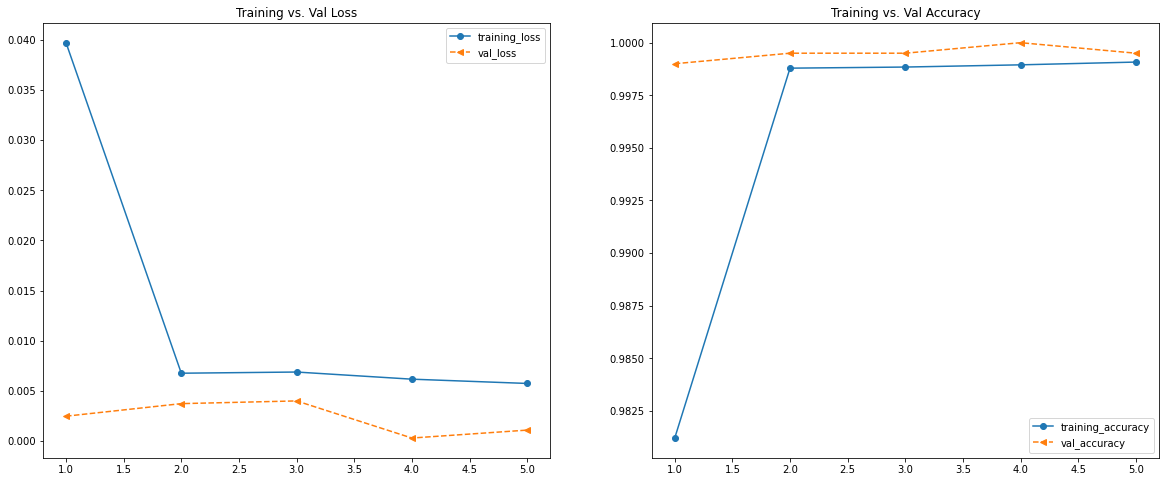

In [20]:
hist = history.history
epochs = np.arange(5) + 1

fig, ax = plt.subplots(1, 2, figsize = (20, 8))

ax[0].plot(epochs, hist['loss'], '-o', label = 'training_loss')
ax[0].plot(epochs, hist['val_loss'], '--<', label = 'val_loss')
ax[0].legend()
ax[0].set_title('Training vs. Val Loss')

ax[1].plot(epochs, hist['accuracy'], '-o', label = 'training_accuracy')
ax[1].plot(epochs, hist['val_accuracy'], '--<', label = 'val_accuracy')
ax[1].legend()
ax[1].set_title('Training vs. Val Accuracy')

In [21]:
model.evaluate(ds_test)

154/154 [==============================] - 16s 101ms/step - loss: 0.0087 - accuracy: 0.9986


[0.00867721438407898, 0.9985708594322205]